In [23]:
import numpy as np
import numba as nb
import os
import matplotlib.pyplot as plt

So i have created a funciton for $\rho$ "density" that inputs T and an matrix of particle masses and g values, and outputs the total density of all the particles in that matrix. This funciton then goes into a function for $g_*$ "gstar" that calculates $g_*$ for the given density, given T and the particle matrix. 
1. How to make g*(T) independent of T??
2. Values are slightly off
3. plotting...???
4. Need to make sure everything is matching up with existing data
5. Way to just do one lepton at a time?


# Fermions

In [57]:
@nb.jit(nopython=True)
def fermion_integrand(x, m, T): 
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))+1) * np.exp(x)

def boson_integrand(x, m, T):
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))-1) * np.exp(x)


x_lagauss, w_lagauss = np.polynomial.laguerre.laggauss(40)
@nb.jit(nopython=True)
def rho(m, g, T):
    rho_vals = (g/2)*T**4/np.pi**2 * fermion_integrand(x_lagauss, m, T) * w_lagauss
    return np.sum(rho_vals)

m_e = 0.511
m_mu = 105.7
m_tau = 1777
mve = 0
mvmu = 0
mvtau = 0

just_pho_and_nu = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2]])
normal_phase = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2], [m_e, 4], [m_mu, 4], [m_tau, 4]])

def density(T, mass_g_vals):
    density_val = 0 
    for mass, g_val in mass_g_vals:
        density_val += rho(mass, g_val, T) 
    return density_val

def gstar(T, mass_g_vals):
    return 30/np.pi**2*density(T, mass_g_vals)/T**4

print('T=10 MeV: photons+neutrinos g*=', gstar(10,just_pho_and_nu))
print('T=500 MeV: photons+neutrinos g*=', gstar(500,just_pho_and_nu))
print('T=10 MeV: photons+neutrinos+leptons g*=', gstar(10,normal_phase))
print('T=500 MeV: photons+neutrinos+leptons g*=', gstar(500,normal_phase))

T=10 MeV: photons+neutrinos g*= 7.000000000003398
T=500 MeV: photons+neutrinos g*= 7.000000000003395
T=10 MeV: photons+neutrinos+leptons g*= 10.509205968162723
T=500 MeV: photons+neutrinos+leptons g*= 15.262174669659451


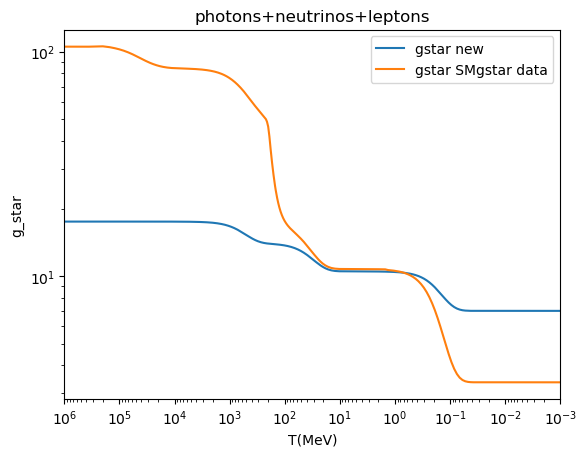

approximately matches for 0-10 MeV


In [48]:
T = np.loadtxt("SMgstar-Copy1.dat", usecols = 0, unpack = True)
gstar_old = np.loadtxt("SMgstar-Copy1.dat", usecols = 1, unpack = True)
#print(T)
gstar_plot_vals = np.zeros(len(T))

for i in range(len(T)):
    gstar_plot_vals[i] = gstar(T[i], normal_phase)
#print(gstar_plot_vals)

plt.figure()
plt.loglog(T, gstar_plot_vals)
plt.loglog(T, gstar_old)
plt.xlim(1e6,1e-3)
plt.ylabel('g_star')
plt.xlabel('T(MeV)')
plt.title('photons+neutrinos+leptons')
plt.legend(['gstar new', 'gstar SMgstar data'])
plt.show()
print('approximately matches for 0-10 MeV')

#### FUNCTION THAT PLOTS $g_*$.. just for fun

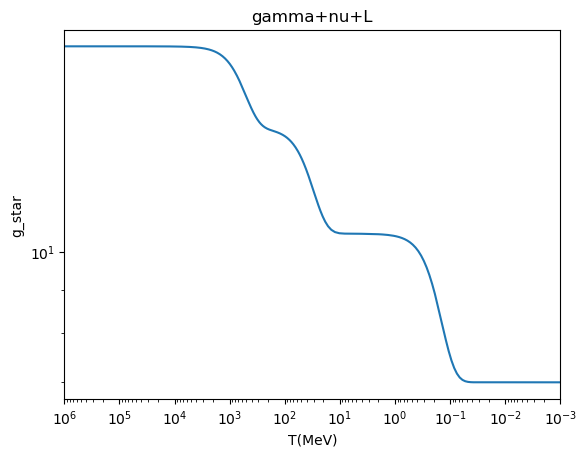

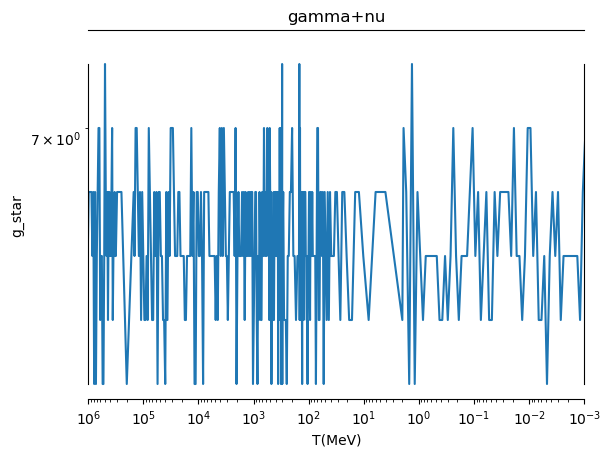

In [56]:
def plot_gstar(T, mass_g_vals, title, lo_x, hi_x):
    for i in range(len(T)):
        gstar_plot_vals[i] = gstar(T[i], mass_g_vals)
    plt.figure()
    plt.loglog(T, gstar_plot_vals)
    plt.xlim(lo_x, hi_x)
    plt.ylabel('g_star')
    plt.xlabel('T(MeV)')
    plt.title(title)
    plt.show()
    
T = np.loadtxt("SMgstar-Copy1.dat", usecols = 0, unpack = True)
gstar_plot_vals = np.zeros(len(T))

plot_gstar(T, normal_phase, 'gamma+nu+L', 1e6, 1e-3)
plot_gstar(T, just_pho_and_nu, 'gamma+nu', 1e6, 1e-3)
#print(gstar_plot_vals)

# Bosons

In [60]:
@nb.jit(nopython=True)
def boson_integrand(x, m, T): 
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))-1) * np.exp(x)

x_lagauss, w_lagauss = np.polynomial.laguerre.laggauss(40)
@nb.jit(nopython=True)
def rho(m, g, T):
    rho_vals = (g/2)*T**4/np.pi**2 * boson_integrand(x_lagauss, m, T) * w_lagauss
    return np.sum(rho_vals)

mesons = 

In [58]:

baryon_array = np.array([[m, g_baryon]])
#wdym with mass less that 1 GeV.. i need mass values for how my code works....
# how do have a loop for g instead of a value



NameError: name 'm' is not defined

# EVERYTHING BELOW IS SCRATCH WORK

In [3]:
#@nb.jit(nopython=True)
def rho_integrand(x, m, T): 
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))+1) * np.exp(x)

x_lagauss, w_lagauss = np.polynomial.laguerre.laggauss(40)
#@nb.jit(nopython=True)
def rho(m, g, T):
    rho_vals = (g/2)*T**4/np.pi**2 * rho_integrand(x_lagauss, m, T) * w_lagauss
    return np.sum(rho_vals)

m_e = 0.511
m_mu = 105.7
m_tau = 1777
mve = 0
mvmu = 0
mvtau = 0
#list of these to loop through?

normal_phase = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2], [m_e, 4], [m_mu, 4], [m_tau, 4]])
just_pho_and_nu = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2]])

#photons neutrinos and charged leptons
def density(T):
    density_val = 0 
    for mass, g_val in normal_phase:
        #density_val = np.sum(rho(mass, g_val, T))
        density_val += rho(mass, g_val, T) 
    return density_val

def gstar(T):
    return 30/np.pi**2*density(T)/T**4



#photons and neutrinos only
def _density_(T):
    density_val_ = 0 
    for mass, g_val in just_pho_and_nu:
        #density_val = np.sum(rho(mass, g_val, T))
        density_val_ += rho(mass, g_val, T) 
    return density_val_


def gstar_(T):
    return 30/np.pi**2*_density_(T)/T**4



T_value = 500  # replace with array for T
gstar_val_ = gstar_(T_value)
print('photons + neutrinos', gstar_val_)
gstar_val = gstar(T_value)
print('photons + neutrinos + leptons',gstar_val)

photons + neutrinos 7.000000000003397
photons + neutrinos + leptons 15.262174669659455


What if instead, density function takes in T and an array, the array is the mass and g values so then i can just use that as a general thing in the funciton.... like this:


In [4]:
normal_phase = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2], [m_e, 4], [m_mu, 4], [m_tau, 4]])
just_pho_and_nu = np.array([[0, 2], [mve, 2], [mvmu, 2], [mvtau, 2]])

def density(T, mass_g_array):
    density_val = 0 
    for mass, g_val in mass_g_array:
        density_val += rho(mass, g_val, T) 
    return density_val

def gstar(T, mass_g_array):
    return 30/np.pi**2*density(T, mass_g_array)/T**4

print('photons+neutrinos+leptons g*=', gstar(500,normal_phase))
print('photons+neutrinos g*=', gstar(500,just_pho_and_nu))

photons+neutrinos+leptons g*= 15.262174669659455
photons+neutrinos g*= 7.000000000003397


In [5]:
T = np.loadtxt("SMgstar-Copy1.dat", usecols = 0, unpack = True)
print(T)
gstar_plot_vals = np.zeros(len(T))

for i in range(len(T)):
    gstar_plot_vals[i] = gstar(T[i])
print(gstar_plot_vals)

plt.loglog(T, gstar_plot_vals)
plt.xlabel('T')
plt.ylabel('gstar')
plt.show()

[5.97154322e-04 6.70018192e-04 7.51772801e-04 8.43502984e-04
 9.46425946e-04 1.06190741e-03 1.19147975e-03 1.33686232e-03
 1.49998424e-03 1.68301005e-03 1.88836840e-03 2.11878427e-03
 2.37731513e-03 2.66739153e-03 2.99286263e-03 3.35804721e-03
 3.76779107e-03 4.22753125e-03 4.74336824e-03 5.32214687e-03
 5.97154721e-03 6.70018639e-03 7.51773303e-03 8.43503547e-03
 9.46426578e-03 1.06190812e-02 1.19148055e-02 1.33686321e-02
 1.49998524e-02 1.68301118e-02 1.88836966e-02 2.11878568e-02
 2.37731672e-02 2.66739332e-02 2.99286462e-02 3.35804945e-02
 3.76779358e-02 4.22753407e-02 4.74337140e-02 5.32215043e-02
 5.97155120e-02 6.70019087e-02 7.51773805e-02 8.43504111e-02
 9.46427210e-02 1.06190883e-01 1.19148134e-01 1.33686410e-01
 1.49998624e-01 1.68301230e-01 1.88837092e-01 2.11878710e-01
 2.37731830e-01 2.66739510e-01 2.99286662e-01 3.35805169e-01
 3.76779610e-01 4.22753689e-01 4.74337457e-01 5.32215398e-01
 5.97155518e-01 6.70019534e-01 7.51774307e-01 8.43504674e-01
 9.46427842e-01 1.061909

TypeError: gstar() missing 1 required positional argument: 'mass_g_array'

In [ ]:

#plot gstar vs T
def gstar(T):
    return 30/np.pi**2*density(T)/T**4

T_vals = np.linspace(500, 10, 100)

#print(T_vals)
    
for i in range(len(T_vals)):
    gstar_plot_vals[i] = gstar(T_vals[i])
    
plt.loglog(T_vals, gstar_plot_vals)
plt.xlabel('T')
plt.ylabel('gstar')
plt.show()